# Multiclass neural

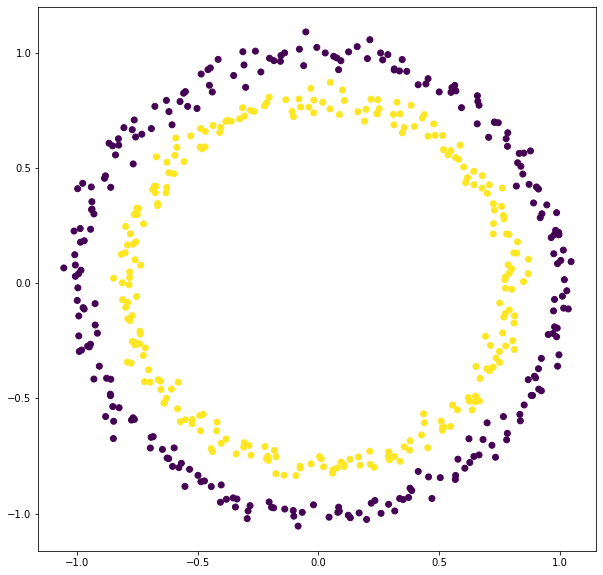

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets        import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix

np.random.seed(42)
N = 500
C,c = make_circles(N, random_state=42, noise=0.03) 
plt.figure(figsize=(10,10))
plt.scatter(C[:,0],C[:,1],c=c)


one_hot = np.zeros((N,2))
for i in range(N):
    one_hot[i, c[i]] = 1

plt.show()

## One hot encoding

Los estímulos son codificados para mostrar un 1 en entrada correspondiente a su valor. Ejemplo

$ 2 = [0,0,1]$

Es un vector de probabilidad en la que la clase i-ésima tiene una probabilidad de aparición $p(i)$.

In [2]:
#imprimimos los primeros 10 ejemplos

from pprint import pprint
pprint(list(zip(c[:10],one_hot[:10])))

[(1, array([0., 1.])),
 (0, array([1., 0.])),
 (1, array([0., 1.])),
 (0, array([1., 0.])),
 (0, array([1., 0.])),
 (1, array([0., 1.])),
 (1, array([0., 1.])),
 (0, array([1., 0.])),
 (0, array([1., 0.])),
 (1, array([0., 1.]))]


Ahora sólo dividimos en conjunto de entrenamiento y prueba

    Ct, ct <- conjunto de entrenamiento y etiquetas asociadas
    Cp, cp <- conjunto de prueba y etiquetas asociadas

In [3]:
Ct, Cp, ct, cp = train_test_split(C,one_hot)

## Softmax

Ahora no solo queremos un valor entre 0 y 1, sino que queremos un vector en el que la salida deseada marque un 1 y las demás 0 (o algo cercano en ambos casos). Es decir no podemos usar $n$ sigmoides porque el valor de cada entrada está condicionada a ser 1 solo si las demás dan 0. 

Esto se puede lograr con la función softmax que nos da la probabilidad $i$-ésima de cada entrada en el vector aleatorio $x$. Función que generaliza a sigmoide. Arroja un vector aleatoria donde cada entrada es la probabilidad de observar la clase en esa entrada, su suma debe dar 1.



$$p_i = \frac {\exp(x_i)} {\sum_{j}^{N} {\exp(x_j)}}$$

### Cross-entropy

Pero ahora no podemos usar el MSE (ni MAE) como nuestra función de error, debemos usar algo que nos permita ponderar el error de haberle 'atinado' a la entrada deseada con un 1, y con un 0 a las demás.

Cross-entropy es la función que generaliza a la función que usamos para el caso binario.

$$CE = -\sum_i^{N} y_i log(x_i) $$

In [4]:
def sigmoide(x):
    return 1/(1+np.exp(-x))

def dsigmoide(y):
    return y*(1-y)
    #return sigmoide(y) *(1-sigmoide (y))

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

costo = lambda t, y: np.sum(-t * np.log(y))

def predict(M, b, X):
    wh, wo = M
    bh, bo = b
    
    zh = np.dot(X, wh) + bh
    ah = sigmoide(zh)

    # Salida
    zo = np.dot(ah, wo) + bo
    ao = softmax(zo)
    return ao

    

## Definición de red

Definimos los metaparámetros de la red.

In [5]:
n = 2
escondidas = 3
m = 2

# Una alternativa equivalente en vez de ocupar una 
# dimensión extra es la de ocupar una transformación afin
# esencialmente y = mx + b
# el proceso de optimizacion debe optimizar (m,b)

wh = np.random.rand(n,escondidas)
bh = np.random.randn(escondidas)

wo = np.random.rand(escondidas,m)
bo = np.random.randn(m)
iters = int(7e4)                   # numero de iteraciones
lr = 10e-4                         # constante de aprendizaje


## Entrenamos

In [6]:

def entrena(X,y, M, b, iters, lr, dim_in, dim_out, N, step=1000):
    """
    Entrenamiento 
    X conjunto de entrenamiento
    y etiquetas 
    iters:   numero de iteraciones
    lr:      constante de aprendizaje
    dim_in:  dimension del conjunto de entrada (Rn)
    dim_out: dimension del vector de salida (Rm)
    N:       num instancias |X|
    M, b:    [wh, wo], [bh, bo]
    """
    errores = []
    ############# desempacamos los pesos
    wh, wo = M
    bh, bo = b
    
    for epoca in range(iters):
    ############# feedforward

        # Escondidas
        zh = np.dot(X, wh) + bh
        ah = sigmoide(zh)

        # Salida
        zo = np.dot(ah, wo) + bo
        ao = softmax(zo)

    ########## Backpropagation

        grad_costo = ao - y
        dzo_dwo = ah

        deltas_wo = np.dot(dzo_dwo.T, grad_costo)
        deltas_bo = grad_costo
 
    
        dzo_dah = wo
        dcost_dah = np.dot(grad_costo , dzo_dah.T)
        dah_dzh = dsigmoide(ah)
        dzh_dwh = X
        
        deltas_wh = np.dot(dzh_dwh.T, dah_dzh * dcost_dah)
        deltas_bh = dcost_dah * dah_dzh

    ########## Actualizacion de pesos
        
        wh -= lr * deltas_wh
        bh -= lr * deltas_bh.sum(axis=0)

        wo -= lr * deltas_wo
        bo -= lr * deltas_bo.sum(axis=0)

        if (epoca % step == 0 or epoca==iters):
            loss = costo(y,ao)
            print('Epoca {} costo {}: '.format(epoca, loss))
            errores.append(loss)
            
    return [wh,wo], [bh,bo], errores

M, b, J = entrena(Ct, ct, [wh, wo], [bh, bo], iters, lr, n, m, N, step=10000)

Epoca 0 costo 449.1460427398421: 
Epoca 10000 costo 63.84678512621779: 
Epoca 20000 costo 34.104414462382366: 
Epoca 30000 costo 24.62135214745387: 
Epoca 40000 costo 19.71582394081834: 
Epoca 50000 costo 16.63630147138259: 
Epoca 60000 costo 14.506213121757945: 


## Evaluamos

Vamos a analizar la evolución de la función de costo y la matriz de confusión

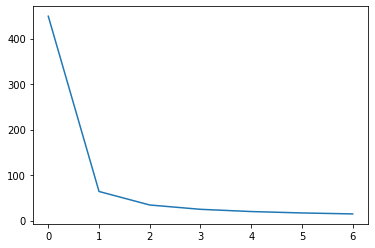

In [7]:
plt.plot(J[:])

In [8]:
yp = np.round(predict(M,b,Cp))
confusion_matrix(np.argmax(yp, axis=1), np.argmax(cp, axis=1))

array([[61,  0],
       [ 0, 64]])

## Visualizamos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


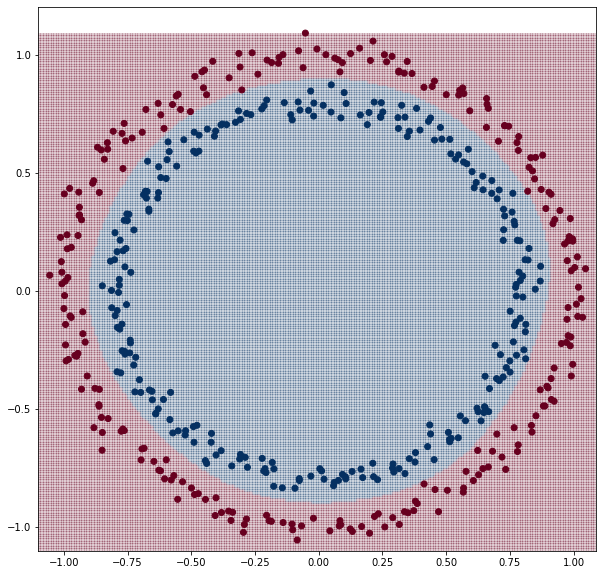

In [9]:
h = 0.01
P = np.arange(-1-.1,1+.1,h)
Q = np.arange(-1-.1,1+.1,h)
Z = np.zeros((len(P), len(Q)))


fig = plt.figure(figsize=(10,10))
for p in range(len(P)):
    for q in range(len(Q)):
        x,y = P[p], Q[q]
        sc = predict(M,b,np.array([[x,y]]))
        #print(sc)
        Z[p,q] = np.argmax(sc)
        
cm = plt.cm.RdBu
plt.pcolor(P,Q,Z, cmap=cm, alpha=0.2)
plt.scatter(C[:,0],C[:,1],c=c, cmap = cm)

Estos pesos no pueden verse por la dimensión en la que están, así que vamos a hacer un proceso de reducción de dimensión

In [10]:
wh, wo = M
bh, bo = b

# capa intermedia

zh = np.dot(Cp, wh) + bh
ah = sigmoide(zh)

# Salida
zo = np.dot(ah, wo) + bo
ao = softmax(zo)


In [11]:
ah

array([[9.96360053e-01, 2.88159660e-01, 4.88816644e-01],
       [9.96601938e-01, 2.93990875e-01, 4.99138568e-01],
       [9.96456826e-01, 3.36269080e-01, 4.47022512e-01],
       [8.36813649e-01, 3.86431543e-03, 5.45237279e-01],
       [9.72459020e-01, 1.08289803e-02, 7.54462073e-01],
       [9.95281950e-01, 5.45398366e-01, 2.26057570e-01],
       [2.43238005e-01, 1.58477815e-03, 1.56597939e-01],
       [9.50316226e-01, 8.65148465e-01, 6.94019741e-03],
       [9.71394912e-01, 9.02794192e-01, 8.69411049e-03],
       [9.86054305e-01, 8.99742191e-01, 1.78351260e-02],
       [4.98948095e-01, 2.92481341e-01, 4.45394989e-03],
       [7.74168695e-01, 1.08541808e-03, 7.10286019e-01],
       [9.94326167e-01, 1.23018702e-01, 6.09620172e-01],
       [9.88921314e-01, 3.02844457e-02, 7.50341714e-01],
       [3.07783964e-01, 4.97299005e-02, 1.22158167e-02],
       [1.19387437e-01, 6.31914736e-03, 2.40382869e-02],
       [8.23490702e-01, 1.36829823e-03, 7.29078957e-01],
       [8.87042147e-01, 6.92474

In [12]:
from numpy import array, linalg as la, cov, dot, argsort, cumsum

def pca(datos, dimens=2):
    m, n = datos.shape
    D = datos[:]; D -= datos.mean(axis=0)
    R = cov(D, rowvar=False)
    evals, evecs = la.eigh(R)
    idx = argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    evecs = evecs[:, :dimens]
    return dot(evecs.T, D.T).T, evals, evecs

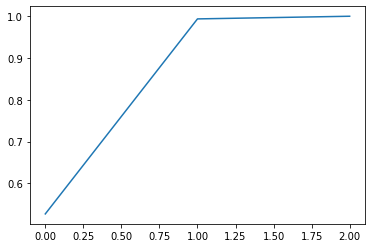

In [13]:
Hr, V, E = pca(ah)
Va = np.array([x/sum(V) for x in V]).cumsum()
plt.plot(Va)

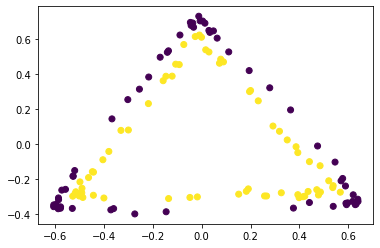

In [14]:
plt.scatter(Hr[:,0], Hr[:,1], c=np.argmax(cp, axis=1))

In [15]:
C = []
for x in Cp:
    C.append(np.arctan(x[1]/x[0])) 


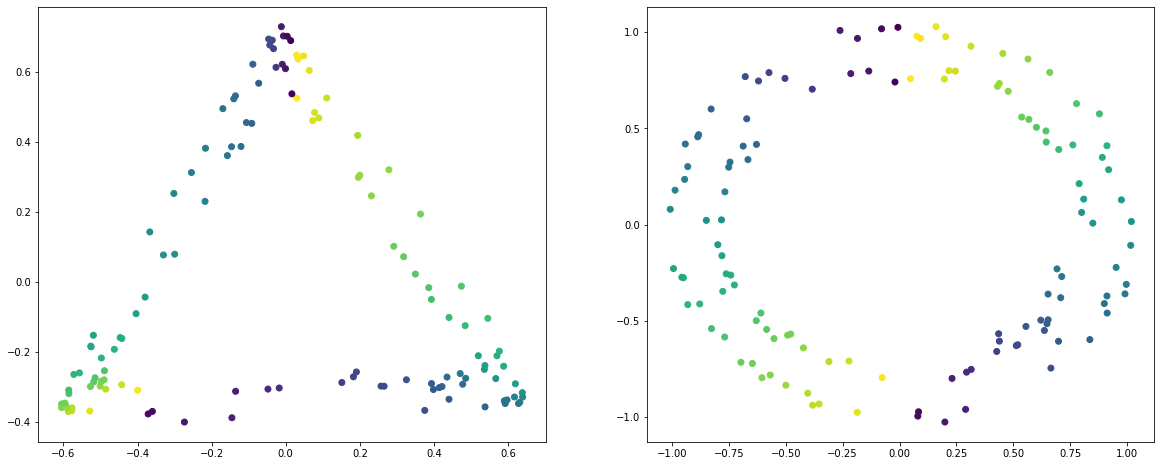

In [18]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].scatter(Hr[:,0], Hr[:,1], c=C)
axs[1].scatter(Cp[:,0], Cp[:,1], c=C)

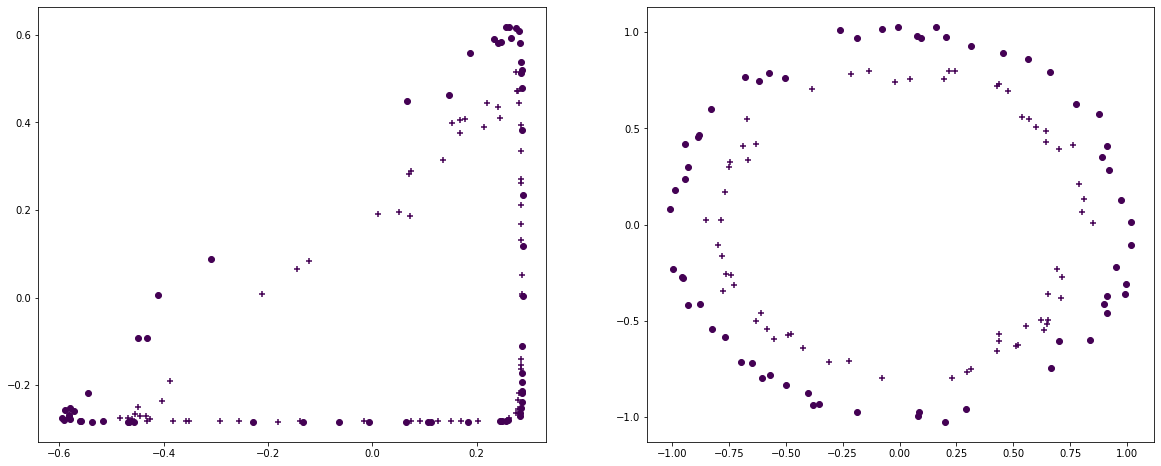

In [208]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

M = np.array(['+' if x==1 else 'o' for x in np.argmax(cp, axis=1)])

for v, _c, _m, w in zip(ah, C, M, Cp):
    axs[0].scatter(v[0], v[1], c=_c, marker=_m)
    axs[1].scatter(w[0], w[1], c=_c, marker=_m)